# Using masks and computing weighted average

This example is based from xarray example http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html

## Import python packages

In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
%matplotlib inline

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,517667
dcpp_init_year,60


## Search data

In [3]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['Amon'], variable_id=['tas'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815


## Create dictionary from the list of datasets we found
- This step may take several minutes so be patient!

In [4]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
list(dset_dict.keys())

['CMIP.NCC.NorESM2-LM.historical.Amon.gn']

In [6]:
dset = dset_dict[list(dset_dict.keys())[0]]
dset

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 144, member_id: 1, time: 1980)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 990, 96, 144), meta=np.ndarray>
Attributes: (12/52)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1600-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     430335.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    tracking_id:               hdl:21.14100/2486cf87-033c-4848-ab3e-e828c3b7c...
    variable_id:               tas
    variant_label:             r1i1p1f1
    intake_esm_varname:        ['tas']
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-LM.historical.Amon.gn

Plot the first timestep

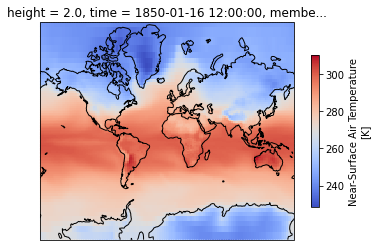

In [7]:
projection = ccrs.Mercator(central_longitude=-10)

f, ax = plt.subplots(subplot_kw=dict(projection=projection))

dset['tas'].isel(time=0).plot(transform=ccrs.PlateCarree(), cbar_kwargs=dict(shrink=0.7), cmap='coolwarm')
ax.coastlines()

## Compute weighted mean

1. Creating weights: for a rectangular grid the cosine of the latitude is proportional to the grid cell area.
2. Compute weighted mean values

In [8]:
def computeWeightedMean(ds):
    # Compute weights based on the xarray you pass
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    # Compute weighted mean
    air_weighted = ds.weighted(weights)
    weighted_mean = air_weighted.mean(("lon", "lat"))
    return weighted_mean

## Compute weighted average over the entire globe

In [9]:
weighted_mean = computeWeightedMean(dset)

## Comparison with unweighted mean
- We select a time range
- Note how the weighted mean temperature is higher than the unweighted.

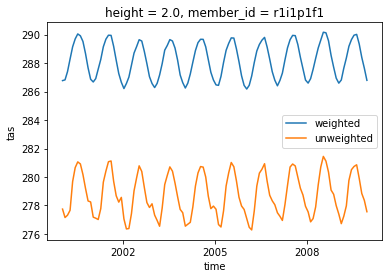

In [10]:
weighted_mean['tas'].sel(time=slice('2000-01-01', '2010-01-01')).plot(label="weighted")
dset['tas'].sel(time=slice('2000-01-01', '2010-01-01')).mean(("lon", "lat")).plot(label="unweighted")

plt.legend()

## Compute Weigted arctic average
Let's try to also take only the data above 60$^\circ$

In [11]:
weighted_mean = computeWeightedMean(dset.where(dset['lat']>60.))

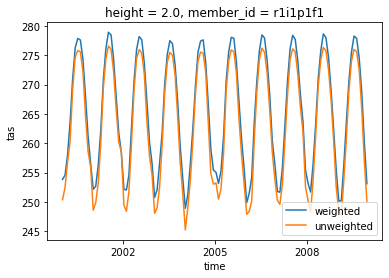

In [12]:
weighted_mean['tas'].sel(time=slice('2000-01-01', '2010-01-01')).plot(label="weighted")
dset['tas'].where(dset['lat']>60.).sel(time=slice('2000-01-01', '2010-01-01')).mean(("lon", "lat")).plot(label="unweighted")

plt.legend()